In [1]:
from tensorflow import keras
import json
import os
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tempfile
import shutil

In [2]:
optimizerAlgorithmOptions = ["adam", "SGD", "RMSprop"]
learningRateOptions = [0.1, 0.01, 0.001, 0.0001]
hiddenLayerOptions = [1, 2, 3]
nodeCountOptions = [5, 10, 15]
epochsOptions = [6, 10, 15]
activationOptions = ["relu", "selu"]
bachSizeOptions = [32, 64, 128]

optionNames = [
    "optimizer",
    "learningRate",
    "hiddenLayer",
    "nodeCount",
    "epochs",
    "activation",
    "bachSize",
]

allOptions = [{optionNames[idx]:option for idx, option in enumerate(optionSet)} for optionSet in itertools.product(
                optimizerAlgorithmOptions,
                learningRateOptions,
                hiddenLayerOptions,
                nodeCountOptions,
                epochsOptions,
                activationOptions,
                bachSizeOptions,
                 )]

def loadRuns():
    temp_dir = tempfile.TemporaryDirectory()
    with zipfile.ZipFile("results.zip", 'r') as zip_ref:
        zip_ref.extractall(temp_dir.name)
    runs = []
    for index, opts in enumerate(allOptions):
        dirPath = f"optimizer_{opts['optimizer']}/learningRate_{opts['learningRate']}/hiddenLayer_{opts['hiddenLayer']}/nodeCount_{opts['nodeCount']}/epochs_{opts['epochs']}/activation_{opts['activation']}/bachSize_{opts['bachSize']}"
        dirPath = os.path.join(temp_dir.name, dirPath)
        if os.path.exists(dirPath):
            if len(os.listdir(dirPath)) != 0:
                with open(f'{dirPath}/history.json', 'r') as f:
                    history = json.load(f)
                with open(f'{dirPath}/testData.json', 'r') as f:
                    testStats = json.load(f)
                
                # Loaing all models takes multiple minutes. I only need the model for the best run (based on validation), so i cheated to make loading time shorter.
                cheatFilterForModelLoading = lambda f: (f["options"]["optimizer"] == "RMSprop") and (f["options"]["learningRate"] == 0.001) and (f["options"]["hiddenLayer"] == 3) and f["options"]["nodeCount"] == 15 and f["options"]["epochs"] == 10 and f["options"]["activation"] == "relu" and f["options"]["bachSize"] == 128
                if (cheatFilterForModelLoading({"options": opts})):
                    model = keras.models.load_model(f'{dirPath}/model')
                else:
                    model = None

                runs.append({"options": opts, "model": model, "history": history, "testStats": testStats})
    temp_dir.cleanup()
    return runs

In [3]:
runs = loadRuns()
print(f'Runs Count: {len(runs)}, Expected: {len(allOptions)}')

Runs Count: 1944, Expected: 1944


Best run:

In [4]:
sortedRuns = sorted(runs, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
for x in sortedRuns[:15]:
    print(f'LastValAccuracy: {x["history"]["val_accuracy"][-1]}, Options:{x["options"]}, TestScore:{x["testStats"]}')

LastValAccuracy: 0.8323809504508972, Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 3, 'nodeCount': 15, 'epochs': 10, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7502857142857143, 'confusion_matrix': [[680, 107], [330, 633]]}
LastValAccuracy: 0.8279365301132202, Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 1, 'nodeCount': 15, 'epochs': 6, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7942857142857143, 'confusion_matrix': [[610, 177], [183, 780]]}
LastValAccuracy: 0.8253968358039856, Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 1, 'nodeCount': 15, 'epochs': 15, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7651428571428571, 'confusion_matrix': [[642, 145], [266, 697]]}
LastValAccuracy: 0.8247619271278381, Options:{'optimizer': 'SGD', 'learningRate': 0.1, 'hiddenLayer': 1, 'nodeCount': 10, 'epochs': 10, 'activation': 'relu', 'bachSize': 

Filter on everything:

In [5]:
filtered = filter(lambda f: (f["options"]["optimizer"] != "") and (f["options"]["learningRate"] == 0.001) and (f["options"]["hiddenLayer"] == 1) and f["options"]["nodeCount"] == 5 and f["options"]["epochs"] == 6 and f["options"]["activation"] == "relu" and f["options"]["bachSize"] == 64, runs)
sortedRuns = sorted(runs, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
for x in sortedRuns[:15]:
    print(f'Options:{x["options"]}, TestScore:{x["testStats"]}')

Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 3, 'nodeCount': 15, 'epochs': 10, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7502857142857143, 'confusion_matrix': [[680, 107], [330, 633]]}
Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 1, 'nodeCount': 15, 'epochs': 6, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7942857142857143, 'confusion_matrix': [[610, 177], [183, 780]]}
Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 1, 'nodeCount': 15, 'epochs': 15, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7651428571428571, 'confusion_matrix': [[642, 145], [266, 697]]}
Options:{'optimizer': 'SGD', 'learningRate': 0.1, 'hiddenLayer': 1, 'nodeCount': 10, 'epochs': 10, 'activation': 'relu', 'bachSize': 32}, TestScore:{'accuracy_score': 0.7651428571428571, 'confusion_matrix': [[612, 175], [236, 727]]}
Options:{'optimizer': 'RMSprop', 'learningRate':

Best SGD Run:

In [6]:
filtered = filter(lambda f: (f["options"]["optimizer"] == "SGD") , runs)
sortedRuns = sorted(runs, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
for x in sortedRuns[:15]:
    print(f'Options:{x["options"]}, TestScore:{x["testStats"]}')

Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 3, 'nodeCount': 15, 'epochs': 10, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7502857142857143, 'confusion_matrix': [[680, 107], [330, 633]]}
Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 1, 'nodeCount': 15, 'epochs': 6, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7942857142857143, 'confusion_matrix': [[610, 177], [183, 780]]}
Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 1, 'nodeCount': 15, 'epochs': 15, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7651428571428571, 'confusion_matrix': [[642, 145], [266, 697]]}
Options:{'optimizer': 'SGD', 'learningRate': 0.1, 'hiddenLayer': 1, 'nodeCount': 10, 'epochs': 10, 'activation': 'relu', 'bachSize': 32}, TestScore:{'accuracy_score': 0.7651428571428571, 'confusion_matrix': [[612, 175], [236, 727]]}
Options:{'optimizer': 'RMSprop', 'learningRate':

In [7]:
filtered = filter(lambda f: (f["options"]["optimizer"] == "adam") , runs)
sortedRuns = sorted(runs, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
for x in sortedRuns[:15]:
    print(f'Options:{x["options"]}, TestScore:{x["testStats"]}')

Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 3, 'nodeCount': 15, 'epochs': 10, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7502857142857143, 'confusion_matrix': [[680, 107], [330, 633]]}
Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 1, 'nodeCount': 15, 'epochs': 6, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7942857142857143, 'confusion_matrix': [[610, 177], [183, 780]]}
Options:{'optimizer': 'RMSprop', 'learningRate': 0.001, 'hiddenLayer': 1, 'nodeCount': 15, 'epochs': 15, 'activation': 'relu', 'bachSize': 128}, TestScore:{'accuracy_score': 0.7651428571428571, 'confusion_matrix': [[642, 145], [266, 697]]}
Options:{'optimizer': 'SGD', 'learningRate': 0.1, 'hiddenLayer': 1, 'nodeCount': 10, 'epochs': 10, 'activation': 'relu', 'bachSize': 32}, TestScore:{'accuracy_score': 0.7651428571428571, 'confusion_matrix': [[612, 175], [236, 727]]}
Options:{'optimizer': 'RMSprop', 'learningRate':

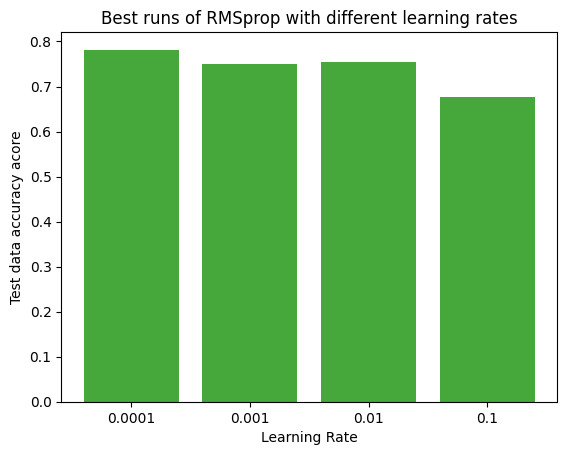

In [8]:
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.0001)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate0 = sortedRuns[0]["testStats"]["accuracy_score"]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.001)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate1 = sortedRuns[0]["testStats"]["accuracy_score"]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.01)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate2 = sortedRuns[0]["testStats"]["accuracy_score"]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.1)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate3 = sortedRuns[0]["testStats"]["accuracy_score"]
x = ['0.0001','0.001', "0.01", "0.1"]
y = [learningrate0, learningrate1, learningrate2, learningrate3]
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='#46a73a')
plt.xlabel("Learning Rate")
plt.ylabel("Test data accuracy acore")
plt.title("Best runs of RMSprop with different learning rates")
plt.xticks(x_pos, x)
plt.show()

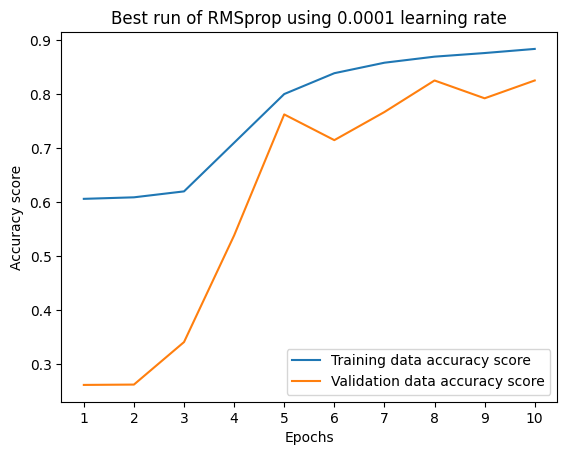

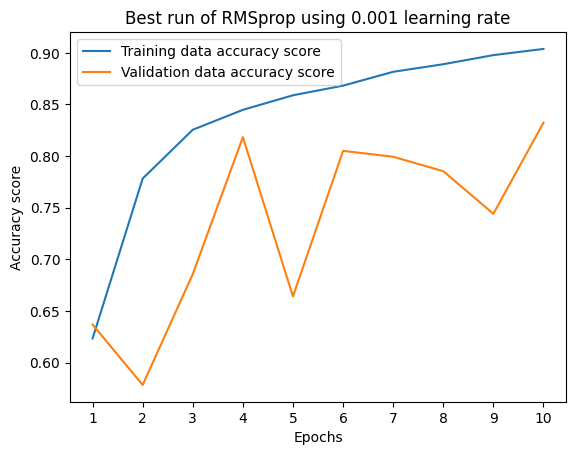

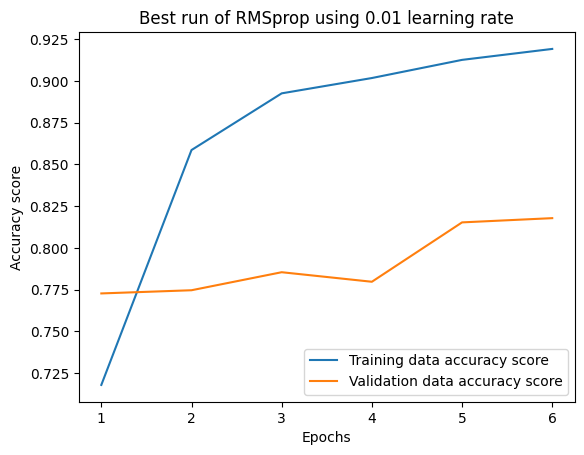

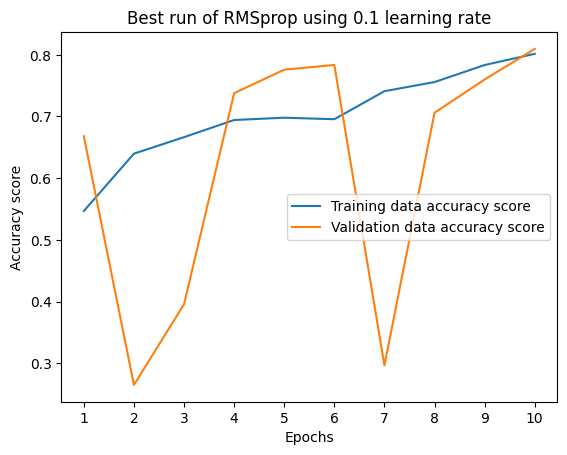

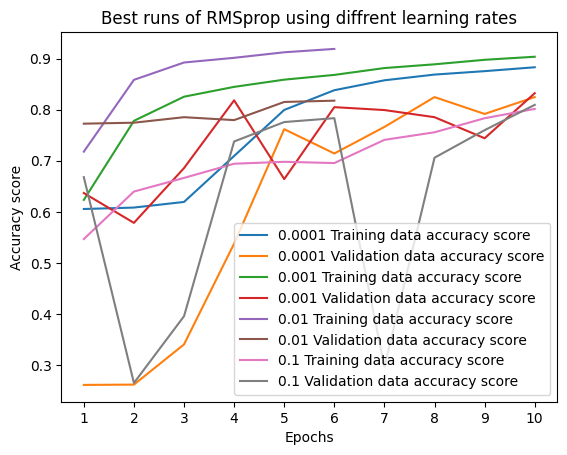

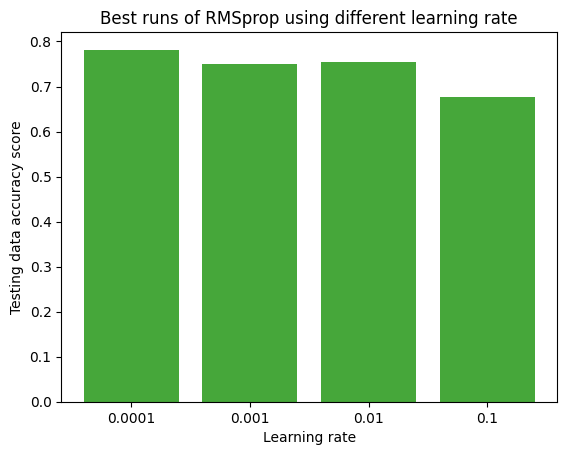

In [9]:
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.0001)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate0 = sortedRuns[0]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.001)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate1 = sortedRuns[0]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.01)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate2 = sortedRuns[0]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.1)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate3 = sortedRuns[0]

y_learningrate0 = learningrate0["history"]["accuracy"]
y_2_learningrate0 = learningrate0["history"]["val_accuracy"]
x_learningrate0 = [f"{i+1}" for i, _ in enumerate(y_learningrate0)]

plt.plot(x_learningrate0, y_learningrate0, label = "Training data accuracy score")
plt.plot(x_learningrate0, y_2_learningrate0, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best run of RMSprop using 0.0001 learning rate")
plt.legend()
plt.show()

y_learningrate1 = learningrate1["history"]["accuracy"]
y_2_learningrate1 = learningrate1["history"]["val_accuracy"]
x_learningrate1 = [f"{i+1}" for i, _ in enumerate(y_learningrate1)]

plt.plot(x_learningrate1, y_learningrate1, label = "Training data accuracy score")
plt.plot(x_learningrate1, y_2_learningrate1, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best run of RMSprop using 0.001 learning rate")
plt.legend()
plt.show()


y_learningrate2 = learningrate2["history"]["accuracy"]
y_2_learningrate2 = learningrate2["history"]["val_accuracy"]
x_learningrate2 = [f"{i+1}" for i, _ in enumerate(y_learningrate2)]

plt.plot(x_learningrate2, y_learningrate2, label = "Training data accuracy score")
plt.plot(x_learningrate2, y_2_learningrate2, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best run of RMSprop using 0.01 learning rate")
plt.legend()
plt.show()

y_learningrate3 = learningrate3["history"]["accuracy"]
y_2_learningrate3 = learningrate3["history"]["val_accuracy"]
x_learningrate3 = [f"{i+1}" for i, _ in enumerate(y_learningrate3)]

plt.plot(x_learningrate3, y_learningrate3, label = "Training data accuracy score")
plt.plot(x_learningrate3, y_2_learningrate3, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best run of RMSprop using 0.1 learning rate")
plt.legend()
plt.show()

plt.plot(x_learningrate0, y_learningrate0, label = "0.0001 Training data accuracy score")
plt.plot(x_learningrate0, y_2_learningrate0, label = "0.0001 Validation data accuracy score")
plt.plot(x_learningrate1, y_learningrate1, label = "0.001 Training data accuracy score")
plt.plot(x_learningrate1, y_2_learningrate1, label = "0.001 Validation data accuracy score")
plt.plot(x_learningrate2, y_learningrate2, label = "0.01 Training data accuracy score")
plt.plot(x_learningrate2, y_2_learningrate2, label = "0.01 Validation data accuracy score")
plt.plot(x_learningrate3, y_learningrate3, label = "0.1 Training data accuracy score")
plt.plot(x_learningrate3, y_2_learningrate3, label = "0.1 Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best runs of RMSprop using diffrent learning rates")
plt.legend()
plt.show()

y = [learningrate0["testStats"]["accuracy_score"], learningrate1["testStats"]["accuracy_score"], learningrate2["testStats"]["accuracy_score"], learningrate3["testStats"]["accuracy_score"]]
x = ["0.0001", "0.001", "0.01", "0.1"]
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='#46a73a')
plt.xlabel("Learning rate")
plt.ylabel("Testing data accuracy score")
plt.title("Best runs of RMSprop using different learning rate")
plt.xticks(x_pos, x)
plt.show()

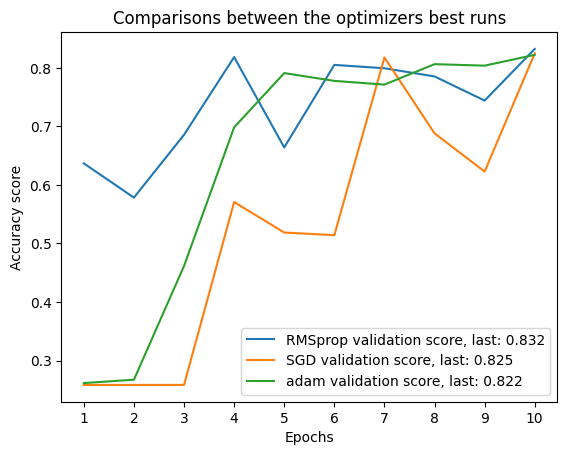

In [10]:
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop") , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
rmsProp = sortedRuns[0]
filtered = filter(lambda f: (f["options"]["optimizer"] == "SGD") , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
sgd = sortedRuns[0]
filtered = filter(lambda f: (f["options"]["optimizer"] == "adam") , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
adam = sortedRuns[0]

y_RMSprop = rmsProp["history"]["val_accuracy"]
y_SGD = sgd["history"]["val_accuracy"]
y_adam = adam["history"]["val_accuracy"]
x_RMSprop = [f"{i+1}" for i, _ in enumerate(y_RMSprop)]
x_SGD = [f"{i+1}" for i, _ in enumerate(y_SGD)]
x_adam = [f"{i+1}" for i, _ in enumerate(y_adam)]
#print(json.dumps([rmsProp, sgd, adam]))

plt.plot(x_RMSprop, y_RMSprop, label = f'RMSprop validation score, last: {y_RMSprop[-1]:.3f}')
plt.plot(x_SGD, y_SGD, label = f'SGD validation score, last: {y_SGD[-1]:.3f}')
plt.plot(x_adam, y_adam, label = f'adam validation score, last: {y_adam[-1]:.3f}')
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Comparisons between the optimizers best runs")
plt.legend()
plt.show()

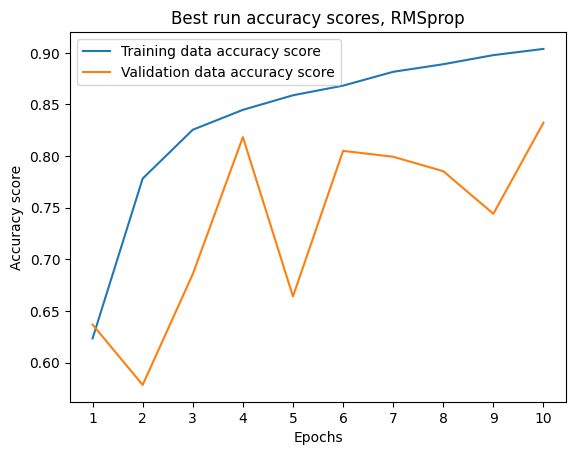

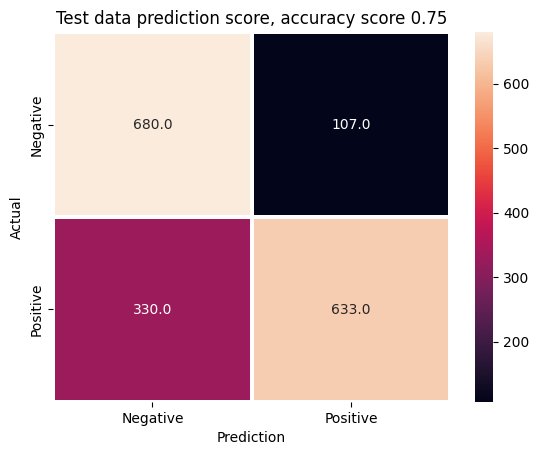

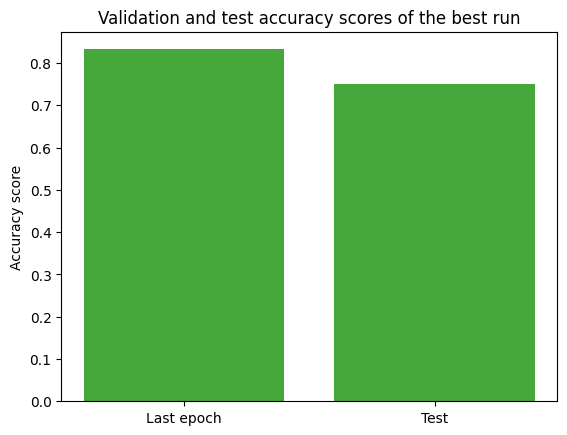

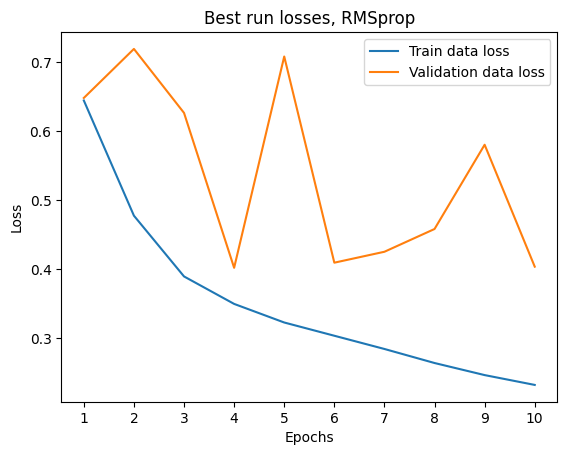

In [11]:
sortedRuns = sorted(runs, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
bestRun = sortedRuns[0]

y_val_accuracy = bestRun["history"]["val_accuracy"]
x_val_accuracy = [f"{i+1}" for i, _ in enumerate(y_val_accuracy)]
y_accuracy = bestRun["history"]["accuracy"]
x_accuracy = [f"{i+1}" for i, _ in enumerate(y_accuracy)]

plt.plot(x_accuracy, y_accuracy, label = "Training data accuracy score")
plt.plot(x_val_accuracy, y_val_accuracy, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title(f'Best run accuracy scores, {bestRun["options"]["optimizer"]}')
plt.legend()
plt.show()

bestRunConfusionMatrix = bestRun["testStats"]["confusion_matrix"]
bestRunTestAccuracyScore = bestRun["testStats"]["accuracy_score"]

labels = ["Negative", "Positive"]

plt.subplots()
sns.heatmap(bestRunConfusionMatrix,annot=True,linewidths=1.5,fmt=".1f", xticklabels=labels, yticklabels=labels)
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.title(f'Test data prediction score, accuracy score {bestRunTestAccuracyScore:.2f}')
plt.show()

y = [bestRun["history"]["val_accuracy"][-1]]
x = ["Last epoch"]
y.append(bestRun["testStats"]["accuracy_score"])
x.append("Test")

x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, y, color='#46a73a')
#plt.xlabel("")
plt.ylabel("Accuracy score")
plt.title("Validation and test accuracy scores of the best run")
plt.xticks(x_pos, x)
plt.show()

y_loss = bestRun["history"]["loss"]
x_loss = [f"{i+1}" for i, _ in enumerate(y_loss)]
y_val_loss = bestRun["history"]["val_loss"]
x_val_loss = [f"{i+1}" for i, _ in enumerate(y_val_loss)]

plt.plot(x_loss, y_loss, label = f'Train data loss')
plt.plot(x_val_loss, y_val_loss, label = f'Validation data loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f'Best run losses, {bestRun["options"]["optimizer"]}')
plt.legend()
plt.show()


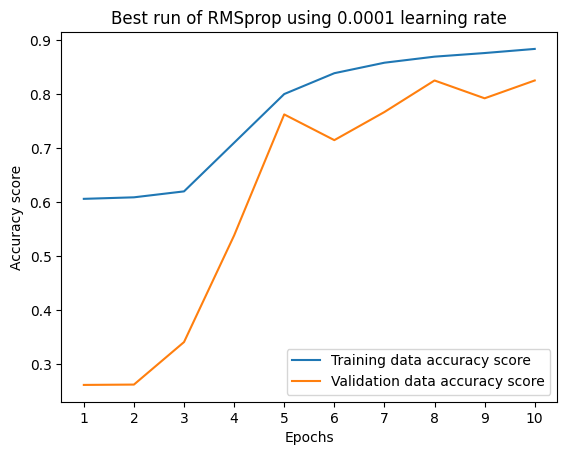

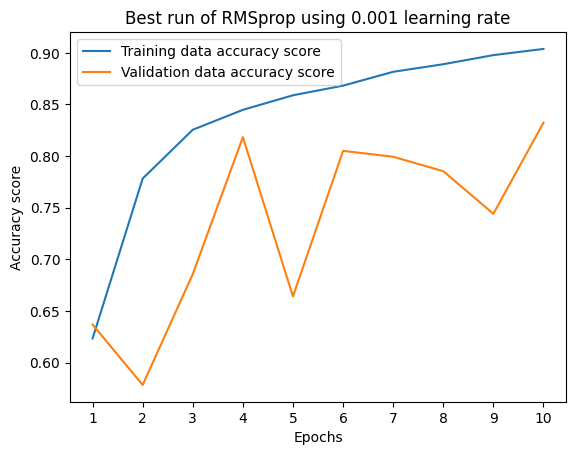

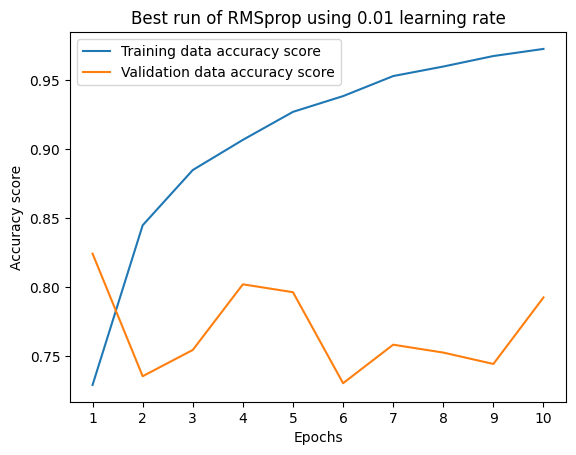

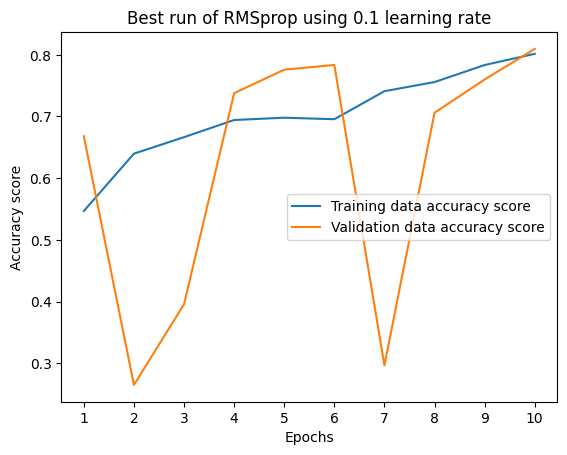

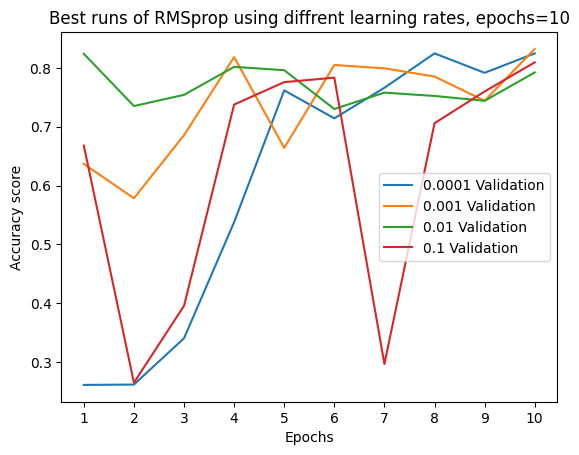

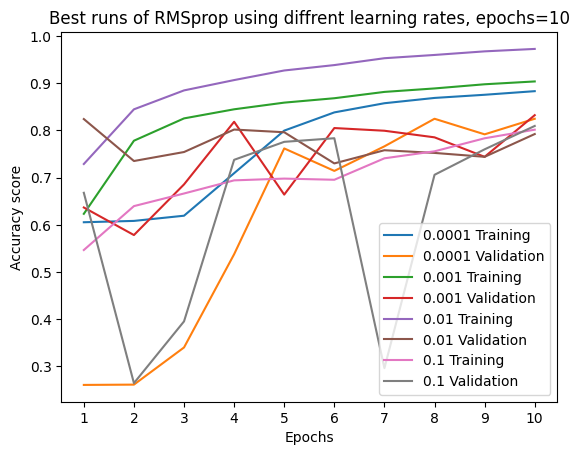

In [12]:
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.0001) and (f["options"]["epochs"] == 10)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate0 = sortedRuns[0]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.001) and (f["options"]["epochs"] == 10)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate1 = sortedRuns[0]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.01) and (f["options"]["epochs"] == 10)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate2 = sortedRuns[0]
filtered = filter(lambda f: (f["options"]["optimizer"] == "RMSprop" and (f["options"]["learningRate"] == 0.1) and (f["options"]["epochs"] == 10)) , runs)
sortedRuns = sorted(filtered, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
learningrate3 = sortedRuns[0]

y_learningrate0 = learningrate0["history"]["accuracy"]
y_2_learningrate0 = learningrate0["history"]["val_accuracy"]
x_learningrate0 = [f"{i+1}" for i, _ in enumerate(y_learningrate0)]

plt.plot(x_learningrate0, y_learningrate0, label = "Training data accuracy score")
plt.plot(x_learningrate0, y_2_learningrate0, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best run of RMSprop using 0.0001 learning rate")
plt.legend()
plt.show()

y_learningrate1 = learningrate1["history"]["accuracy"]
y_2_learningrate1 = learningrate1["history"]["val_accuracy"]
x_learningrate1 = [f"{i+1}" for i, _ in enumerate(y_learningrate1)]

plt.plot(x_learningrate1, y_learningrate1, label = "Training data accuracy score")
plt.plot(x_learningrate1, y_2_learningrate1, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best run of RMSprop using 0.001 learning rate")
plt.legend()
plt.show()


y_learningrate2 = learningrate2["history"]["accuracy"]
y_2_learningrate2 = learningrate2["history"]["val_accuracy"]
x_learningrate2 = [f"{i+1}" for i, _ in enumerate(y_learningrate2)]

plt.plot(x_learningrate2, y_learningrate2, label = "Training data accuracy score")
plt.plot(x_learningrate2, y_2_learningrate2, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best run of RMSprop using 0.01 learning rate")
plt.legend()
plt.show()

y_learningrate3 = learningrate3["history"]["accuracy"]
y_2_learningrate3 = learningrate3["history"]["val_accuracy"]
x_learningrate3 = [f"{i+1}" for i, _ in enumerate(y_learningrate3)]

plt.plot(x_learningrate3, y_learningrate3, label = "Training data accuracy score")
plt.plot(x_learningrate3, y_2_learningrate3, label = "Validation data accuracy score")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best run of RMSprop using 0.1 learning rate")
plt.legend()
plt.show()

plt.plot(x_learningrate0, y_2_learningrate0, label = "0.0001 Validation")
plt.plot(x_learningrate1, y_2_learningrate1, label = "0.001 Validation")
plt.plot(x_learningrate2, y_2_learningrate2, label = "0.01 Validation")
plt.plot(x_learningrate3, y_2_learningrate3, label = "0.1 Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best runs of RMSprop using diffrent learning rates, epochs=10")
plt.legend()
plt.show()

plt.plot(x_learningrate0, y_learningrate0, label = "0.0001 Training")
plt.plot(x_learningrate0, y_2_learningrate0, label = "0.0001 Validation")
plt.plot(x_learningrate1, y_learningrate1, label = "0.001 Training")
plt.plot(x_learningrate1, y_2_learningrate1, label = "0.001 Validation")
plt.plot(x_learningrate2, y_learningrate2, label = "0.01 Training")
plt.plot(x_learningrate2, y_2_learningrate2, label = "0.01 Validation")
plt.plot(x_learningrate3, y_learningrate3, label = "0.1 Training")
plt.plot(x_learningrate3, y_2_learningrate3, label = "0.1 Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy score")
plt.title("Best runs of RMSprop using diffrent learning rates, epochs=10")
plt.legend()
plt.show()

In [13]:
from math import sqrt
significance_level = 1.96 # 95% significance
error = 1 - 0.832
validtion_length = 1574
interval = significance_level * sqrt(error * (1-error) / validtion_length)
print(interval)

0.018470132516350216


x_singleTest: Early Access Reviewgame is amzing better then all other battle royale games.the graphics are amzing but still relativle easy to run.love thats its only ww2 gun i do recommed adding anti tanke rifles.the small amount of playyers in a battle make the game more fun as u dont run into people every 10 seconds.i highly recommend this game
y_singleTest: Positive review


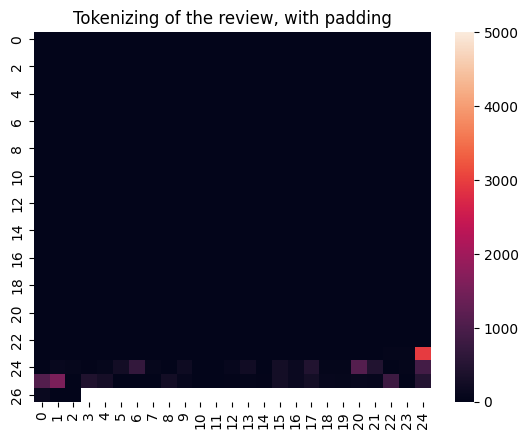

Model: "sequential_704"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_704 (Embedding)   (None, 653, 16)           80000     
                                                                 
 dense_2156 (Dense)          (None, 653, 15)           255       
                                                                 
 dense_2157 (Dense)          (None, 653, 15)           240       
                                                                 
 dense_2158 (Dense)          (None, 653, 15)           240       
                                                                 
 flatten_704 (Flatten)       (None, 9795)              0         
                                                                 
 dense_2159 (Dense)          (None, 1)                 9796      
                                                                 
Total params: 90,531
Trainable params: 90,531
Non-tr

In [25]:
sortedRuns = sorted(runs, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
bestRun = sortedRuns[0]
model = bestRun["model"]
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from pandas import read_csv
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
VOCABULARY_SIZE = 5000

def tokenize(x, tokenizer_json=None, max_length=None):

    tokenizer = tokenizer_from_json(tokenizer_json)
    
    x_tokens = tokenizer.texts_to_sequences(x)

    x_tokens_padded = pad_sequences(x_tokens, maxlen=max_length)
    x_padded_array = np.array(x_tokens_padded)

    return x_padded_array
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n):
        yield l[i:i + n]


data = read_csv("train.csv", header=0)
test = data.iloc[ int(len(data) * .90) : ]
x_test, y_test = test['user_review'].to_numpy(), test['user_suggestion'].to_numpy()

# Select which review from test data to look into.
singleTestIndex = 1020

x_singleTest, y_singleTest = x_test[singleTestIndex], y_test[singleTestIndex]
# gotten from automate.py, but can be seen in the models shape (middle column)
max_length = 653

print(f'x_singleTest: {x_singleTest}')
print(f'y_singleTest: {"Positive" if y_singleTest == 1 else "Negative"} review')

with open('tokenizer.json') as f:
    tokenizer_json = json.load(f)
x_padded_singleTest = tokenize([x_singleTest], tokenizer_json, max_length)[0]

sqareLength = math.floor(sqrt(len(x_padded_singleTest)))
dftmp = divide_chunks(x_padded_singleTest, sqareLength)
padded_dataframe = pd.DataFrame(dftmp)

plt.subplots()
sns.heatmap(padded_dataframe, annot=False, vmin=0, vmax=VOCABULARY_SIZE)
plt.title(f'Tokenizing of the review, with padding')
plt.show()

print(model.summary())
print()

predicted_single = model.predict(np.array( [x_padded_singleTest,] ))

predicted_single_correction = ((predicted_single > 0.5).astype("int32"))

print(f'Prediction: {predicted_single}, discrete_prediction: {"Positive" if predicted_single_correction == 1 else "Negative"} review')

1009
x_singleTest: I cant log into my phone account it says sign up and i try to sign into my phone account but it says account email alrady in use but i know this is not my account because i only have 50 medallions on pc but on mobile i have 1000 so and then theres no sign in button to sign into my account only sign UP not IN so its not working im really frustrated i only want to play with my friedns but theres no sign in button
y_singleTest: Negative review


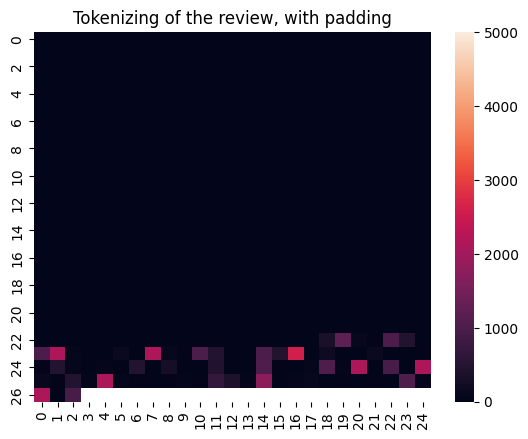

Model: "sequential_704"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_704 (Embedding)   (None, 653, 16)           80000     
                                                                 
 dense_2156 (Dense)          (None, 653, 15)           255       
                                                                 
 dense_2157 (Dense)          (None, 653, 15)           240       
                                                                 
 dense_2158 (Dense)          (None, 653, 15)           240       
                                                                 
 flatten_704 (Flatten)       (None, 9795)              0         
                                                                 
 dense_2159 (Dense)          (None, 1)                 9796      
                                                                 
Total params: 90,531
Trainable params: 90,531
Non-tr

In [24]:
sortedRuns = sorted(runs, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
bestRun = sortedRuns[0]
model = bestRun["model"]
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from pandas import read_csv
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
VOCABULARY_SIZE = 5000

def tokenize(x, tokenizer_json=None, max_length=None):

    tokenizer = tokenizer_from_json(tokenizer_json)
    
    x_tokens = tokenizer.texts_to_sequences(x)

    x_tokens_padded = pad_sequences(x_tokens, maxlen=max_length)
    x_padded_array = np.array(x_tokens_padded)

    return x_padded_array
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n):
        yield l[i:i + n]


data = read_csv("train.csv", header=0)
test = data.iloc[ int(len(data) * .90) : ]
x_test, y_test = test['user_review'].to_numpy(), test['user_suggestion'].to_numpy()

print([idx for idx, s in enumerate(x_test) if 'I cant log into my phone account it says sign up' in s][0])
# Select which review from test data to look into.
singleTestIndex = 1009 # 1009 # 1010

x_singleTest, y_singleTest = x_test[singleTestIndex], y_test[singleTestIndex]
# gotten from automate.py, but can be seen in the models shape (middle column)
max_length = 653

print(f'x_singleTest: {x_singleTest}')
print(f'y_singleTest: {"Positive" if y_singleTest == 1 else "Negative"} review')

with open('tokenizer.json') as f:
    tokenizer_json = json.load(f)
x_padded_singleTest = tokenize([x_singleTest], tokenizer_json, max_length)[0]

sqareLength = math.floor(sqrt(len(x_padded_singleTest)))
dftmp = divide_chunks(x_padded_singleTest, sqareLength)
padded_dataframe = pd.DataFrame(dftmp)

plt.subplots()
sns.heatmap(padded_dataframe, annot=False, vmin=0, vmax=VOCABULARY_SIZE)
plt.title(f'Tokenizing of the review, with padding')
plt.show()

print(model.summary())
print()

predicted_single = model.predict(np.array( [x_padded_singleTest,] ))

predicted_single_correction = ((predicted_single > 0.5).astype("int32"))

print(f'Prediction: {predicted_single}, discrete_prediction: {"Positive" if predicted_single_correction == 1 else "Negative"} review')

1145
x_singleTest: Early Access ReviewКто-то может запрыгнуть максимум на забор, кто-то запрыгивает НА КРЫШУ ДОМА. Кто-то умудряется залезть на чердак, я ещё не замечал выходов на чердак. Прицел очень мутный, окна в разводах. Исправьте.
y_singleTest: Negative review


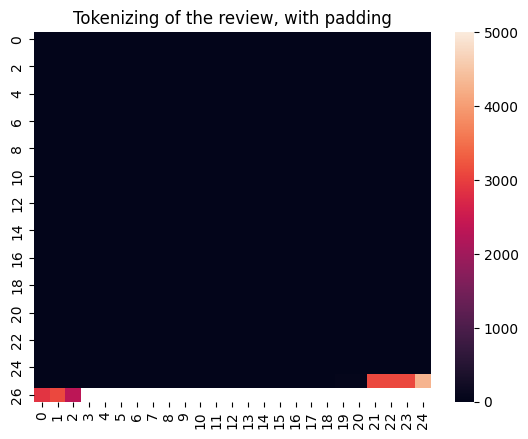

Model: "sequential_704"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_704 (Embedding)   (None, 653, 16)           80000     
                                                                 
 dense_2156 (Dense)          (None, 653, 15)           255       
                                                                 
 dense_2157 (Dense)          (None, 653, 15)           240       
                                                                 
 dense_2158 (Dense)          (None, 653, 15)           240       
                                                                 
 flatten_704 (Flatten)       (None, 9795)              0         
                                                                 
 dense_2159 (Dense)          (None, 1)                 9796      
                                                                 
Total params: 90,531
Trainable params: 90,531
Non-tr

In [23]:
sortedRuns = sorted(runs, key=(lambda f: f["history"]["val_accuracy"][-1]), reverse=True)
bestRun = sortedRuns[0]
model = bestRun["model"]
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from pandas import read_csv
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
VOCABULARY_SIZE = 5000

def tokenize(x, tokenizer_json=None, max_length=None):

    tokenizer = tokenizer_from_json(tokenizer_json)
    
    x_tokens = tokenizer.texts_to_sequences(x)

    x_tokens_padded = pad_sequences(x_tokens, maxlen=max_length)
    x_padded_array = np.array(x_tokens_padded)

    return x_padded_array
def divide_chunks(l, n):
    # looping till length l
    for i in range(0, len(l), n):
        yield l[i:i + n]


data = read_csv("train.csv", header=0)
test = data.iloc[ int(len(data) * .90) : ]
x_test, y_test = test['user_review'].to_numpy(), test['user_suggestion'].to_numpy()

print([idx for idx, s in enumerate(x_test) if 'Early Access ReviewКто-то может' in s][0])
# Select which review from test data to look into.
singleTestIndex = 1145 # 1009 # 1010

x_singleTest, y_singleTest = x_test[singleTestIndex], y_test[singleTestIndex]
# gotten from automate.py, but can be seen in the models shape (middle column)
max_length = 653

print(f'x_singleTest: {x_singleTest}')
print(f'y_singleTest: {"Positive" if y_singleTest == 1 else "Negative"} review')

with open('tokenizer.json') as f:
    tokenizer_json = json.load(f)
x_padded_singleTest = tokenize([x_singleTest], tokenizer_json, max_length)[0]

sqareLength = math.floor(sqrt(len(x_padded_singleTest)))
dftmp = divide_chunks(x_padded_singleTest, sqareLength)
padded_dataframe = pd.DataFrame(dftmp)

plt.subplots()
sns.heatmap(padded_dataframe, annot=False, vmin=0, vmax=VOCABULARY_SIZE)
plt.title(f'Tokenizing of the review, with padding')
plt.show()

print(model.summary())
print()

predicted_single = model.predict(np.array( [x_padded_singleTest,] ))

predicted_single_correction = ((predicted_single > 0.5).astype("int32"))

print(f'Prediction: {predicted_single}, discrete_prediction: {"Positive" if predicted_single_correction == 1 else "Negative"} review')